# Founders Online Gensim LDA topic model


## installing and importing packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install gensim and pyLDAvis (run in terminal/prompt)
#!pip install gensim --upgrade
#!pip install pyLDAvis

In [ ]:
# Install spaCy (run in terminal/prompt)
#import sys
#!{sys.executable} -m pip install spacy

# Download spaCy's  'en' Model
#!{sys.executable} -m spacy download en
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('wordnet')
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Founders correspondence thesis/Data/Archive data/founders_online_archive_cooked.csv', delimiter=",")
df.sample(3)

,Unnamed: 0,index,id,title,permalink,project,authors,recipients,date_from,date_to,api,og_text,text,period
7427,7427,7582,7583,"From Alexander Hamilton to Daniel Bradley, 14 ...",https://founders.archives.gov/documents/Hamilt...,Hamilton Papers,"Hamilton, Alexander","Bradley, Daniel",1799-10-14,1799-10-14,https://founders.archives.gov/API/docdata/Hami...,\r\n \r\n Sir.\r\n ...,Sir. Trenton October 14th. 1799 I have receive...,Adams Presidency
62658,62658,78594,78595,"To John Adams from Ward Nicholas Boylston, 27 ...",https://founders.archives.gov/documents/Adams/...,Adams Papers,"Boylston, Ward Nicholas","Adams, John",1816-09-27,1816-09-27,https://founders.archives.gov/API/docdata/Adam...,\r\n\t\t\t\t\r\n\t\t\t\t\tMy Dear Cousin and F...,My Dear Cousin and Friend Jamaica plain Roxbur...,Madison Presidency
10176,10176,11332,11333,"From George Washington to Alexander Hamilton, ...",https://founders.archives.gov/documents/Washin...,Washington Papers,"Washington, George","Hamilton, Alexander",1799-06-19,1799-06-19,https://founders.archives.gov/API/docdata/Wash...,"\r\n\r\nDear Sir,\r\nMount Vernon, June 19th 1...","Dear Sir, Mount Vernon, June 19th 1799 Your fa...",Adams Presidency


## Preprocessing

Some important things to keep in mind when doing a Topic Modeling:

- stopwords should be removed, they are noisy
- we can aggregate the data by using lemmas (Gensim documentation shows how to do it)
- in case of Twitter data, we can remove all strings that contains URL addresses (e.g. 'http://' and 'https://') - this can be done using the regular expressions library 
- we could use only nouns (for instance)
- we could aggregate the data using bigrams or trigranms (Gensim documentation shows how to do it)
- use only words that have an absolute frequency higher than a specific threshold
- we can find additional solutions on the basis of the data we are working on (really, sky is the limit when it comes to pre-proceesing)

In this example, we tokenize our data using `simple_preprocess()` available in Gensim. This pre-processing does a very basic tokenization,  lowercases everything and optionally remove accents (you can use this when working with languages like Italian, Spanish, French, and many others). 

The function `remove_stopwords()` below takes in input a list of documents, tokenize them using `simple_preprocess()`, and additionally remove stopwords

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

stop_words = nltk.corpus.stopwords.words('english')
stop_words_fr = nltk.corpus.stopwords.words('french')
newStopWords = ['shall','one','could','would', 'upon','may','&','every','much','might', 'with', 'without','two','us','yet',
                'since','also','therefore','however','never','ever','soon','say','take','give','well','see','mch','sir','mr','mr.','get','give'
               , 'want','many','part','time', 'wh','ditto','day','letter','esqr','mrs'] 
stop_words.extend(stop_words_fr + newStopWords)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data = df['text']
data_words_nostops = remove_stopwords(data)

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Form Bigrams and Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only nouns
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])

[['yesterday', 'favour', 'th', 'fortune', 'number', 'news', 'paper', 'care', 'formd', 'expectation', 'adventure', 'promotion', 'science_literature', 'shilling', 'hand', 'purchase', 'book', 'engageing', 'simplicity_manner', 'congratulation', 'event', 'acknowledgment', 'gift', 'people', 'deposit', 'exertion', 'head', 'trust', 'intention', 'conduct', 'offence', 'station', 'envy', 'plant', 'thorn', 'fashion', 'world', 'hope', 'estimate', 'value', 'place', 'enjoyment', 'life', 'retire', 'predecessor', 'friend', 'number', 'field', 'friend']]


In [ ]:
#allows you to optionally save the data
#topic_model_data = pd.Series(data_lemmatized)
#topic_model_data.to_csv('/content/drive/Shareddrives/Founders correspondence thesis/Data/Topic model data/preprocessed_data.csv',header=False, index=False)

## Building an optimized LDA model

In [ ]:
#allows you to optionally load the data back in
#import ast
#preprocessed_data = pd.read_csv('/content/drive/Shareddrives/Founders correspondence thesis/Data/Topic model data/preprocessed_data.csv', header=None)
#preprocessed_data['data'] = preprocessed_data[0].apply(lambda x: ast.literal_eval(x))
#data_lemmatized = preprocessed_data['data'].tolist()

Here is where Gensim prepare the data to apply the topic modeling.

- `corpora.Dictionary` = creates the vocabulary of the corpus (the vocabulary of all texts in our dataset) and associates it to a unique id. Words are represented by unique ids.

- `id2word.doc2bow()` = creates a Bag-of-words corpus. Basically, every document is represeted by a list (a bag) of words. `doc2bow`requires that the vocabular (id2word) is applied to a tokenized document represented as a list (text). Then it associates to every word in the document the corresposnding index in the vocabulary and its freqency in the document.


In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

Now we can instantiate the LDA Topic Modeling.

Some explanation of the parameters:
    
- `corpus` : the bag of word corpus we have created in the previous cell
- `id2word`: the vocabulary index
- `num_topic`: the number of topics we want to create
- `random_state`: a number (seed) to replicate the results if the topic modeling is run by someone else or at a different moment
- `update_every`: Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
- `chunksize`: Number of documents to be used in each training chunk (i.e., how many documents are processed at a time in the training algorithm). The higher the better, but it depends also on the number of documents we have in the corpus! With big collections of documents you can use vaues like 100 or higher.
- `passes`: Number of passes through the corpus during training (i.e., how often we train the model on the entire corpus; how often we repeat a particular loop over each document)
- `per_word_topics`: If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word, along with their phi values multiplied by the feature length (i.e. word count).


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, random_state=42, per_word_topics=True):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list = []
    coherence_values = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)
    return model_list, coherence_values, perplexity_values


In [ ]:
# Can take a long time to run.
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts,
                                                                           start=2, limit=50, step=6, random_state=42, per_word_topics=True)

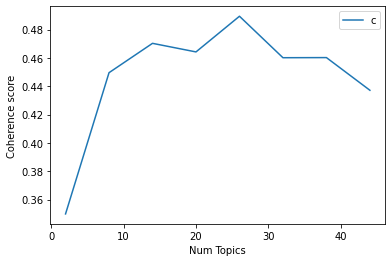

In [ ]:
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3499
Num Topics = 8  has Coherence Value of 0.4496
Num Topics = 14  has Coherence Value of 0.4703
Num Topics = 20  has Coherence Value of 0.4642
Num Topics = 26  has Coherence Value of 0.4894
Num Topics = 32  has Coherence Value of 0.4601
Num Topics = 38  has Coherence Value of 0.4602
Num Topics = 44  has Coherence Value of 0.4372


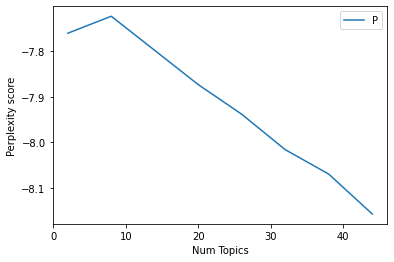

In [ ]:
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("Perplexity_values"), loc='best')
plt.show()


In [ ]:
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))

Num Topics = 2  has Perplexity Value of -7.7599
Num Topics = 8  has Perplexity Value of -7.7225
Num Topics = 14  has Perplexity Value of -7.7977
Num Topics = 20  has Perplexity Value of -7.8728
Num Topics = 26  has Perplexity Value of -7.938
Num Topics = 32  has Perplexity Value of -8.0159
Num Topics = 38  has Perplexity Value of -8.0696
Num Topics = 44  has Perplexity Value of -8.1572


## Selecting and describing optimal model

In [ ]:
#saving the optimal LDA model
optimal_model = model_list[4]
temp_file = datapath("/content/drive/Shareddrives/Founders correspondence thesis/Code/Topic Model/lda_model")
optimal_model.save(temp_file)

In [ ]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(24,
  '0.050*"money" + 0.039*"sum" + 0.037*"debt" + 0.031*"interest" + '
  '0.031*"payment" + 0.026*"dollar" + 0.023*"loan" + 0.022*"bill" + '
  '0.020*"year" + 0.017*"amount"'),
 (11,
  '0.053*"letter" + 0.052*"paper" + 0.028*"copy" + 0.024*"yesterday" + '
  '0.020*"honor" + 0.019*"respect" + 0.019*"information" + 0.016*"order" + '
  '0.016*"hand" + 0.016*"president"'),
 (23,
  '0.073*"law" + 0.044*"case" + 0.033*"court" + 0.021*"person" + '
  '0.018*"opinion" + 0.016*"act" + 0.015*"attorney" + 0.014*"proceeding" + '
  '0.013*"state" + 0.013*"district"'),
 (15,
  '0.042*"water" + 0.032*"mill" + 0.029*"foot" + 0.025*"boat" + 0.022*"wood" + '
  '0.018*"side" + 0.018*"surveyor" + 0.016*"route" + 0.015*"mile" + '
  '0.015*"timber"'),
 (10,
  '0.047*"state" + 0.041*"government" + 0.033*"people" + 0.017*"country" + '
  '0.016*"member" + 0.015*"measure" + 0.013*"assembly" + 0.011*"power" + '
  '0.010*"legislature" + 0.009*"citizen"'),
 (18,
  '0.045*"friend" + 0.033*"family" + 0.019*"year"

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.120423  0.047710       1        1  10.824018
22    -0.172264 -0.034640       2        1   7.982771
2     -0.173159  0.090843       3        1   7.720459
18    -0.055875 -0.084833       4        1   7.502346
10    -0.167020  0.083294       5        1   6.977589
16    -0.082154 -0.053076       6        1   5.828230
3     -0.185024  0.083900       7        1   5.199199
11    -0.101327 -0.055666       8        1   4.877935
7     -0.126557  0.027124       9        1   4.730234
0     -0.133938  0.143677      10        1   4.197823
24    -0.061058 -0.047641      11        1   4.093608
19    -0.093128 -0.027127      12        1   4.016978
23    -0.141736  0.098900      13        1   3.592942
4      0.062800 -0.233199      14        1   3.373883
20     0.023285 -0.079881      15        1   3.274994
17     0.081062 -0.166894      16        1   2.781753
21    -0.044256  0.024754      17        1   1.972470
1      0.045658 -0.045510      18        1   1.736347
6      0.101470 -0.052836      19        1   1.556301
5     -0.019281 -0.016656      20        1   1.535177
8      0.156735 -0.147096      21        1   1.356445
15     0.214441 -0.120606      22        1   1.335906
25     0.218406  0.292236      23        1   1.074762
13     0.308043  0.265310      24        1   0.874388
9      0.255123  0.031378      25        1   0.800577
12     0.210176 -0.023463      26        1   0.782865, topic_info=            Term          Freq         Total Category  logprob  loglift
416       vessel  31130.000000  31130.000000  Default  30.0000  30.0000
4343  excellency  24100.000000  24100.000000  Default  29.0000  29.0000
939      officer  37128.000000  37128.000000  Default  28.0000  28.0000
660         land  17797.000000  17797.000000  Default  27.0000  27.0000
934          law  31836.000000  31836.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
877        sheet    310.256246    735.697975  Topic26  -5.2790   3.9865
1290  invitation    338.353278   1297.941724  Topic26  -5.1923   3.5055
7017       seize    246.616941    427.885130  Topic26  -5.5086   4.2989
1862        tour    267.285738   1498.679712  Topic26  -5.4281   3.1259
81         visit    257.586701   5296.529111  Topic26  -5.4651   1.8265

[1815 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
3729       3  0.989538    abandonment
3729       5  0.008757    abandonment
563        1  0.272302        ability
563        2  0.034314        ability
563        3  0.020267        ability
...      ...       ...            ...
6781      13  0.055344             yr
6781      20  0.002913             yr
38390      8  0.998058  yr_mo_ob_serv
6121      21  0.992907      également
6087      12  0.992705        œconomy

[8638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 23, 3, 19, 11, 17, 4, 12, 8, 1, 25, 20, 24, 5, 21, 18, 22, 2, 7, 6, 9, 16, 26, 14, 10, 13])

## Model output

In [1]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()


NameError: ignored

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()


NameError: ignored

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()


In [ ]:
#adding the data back to the original dataset
df['dominant_topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df['topic_keywords'] = df_topic_sents_keywords['Topic_Keywords']
df.drop(columns=['Unnamed: 0','index']).to_csv('/content/drive/Shareddrives/Founders correspondence thesis/Data/Topic model data/Founders_archive_with_topics')